Nova Variável Alvo (y): 'age_head'
Novas Variáveis Preditoras (x): ['n_members', 'children', 'rooms', 'urban', 'region', 'internet', 'household_income']

Colunas numéricas para previsão: ['n_members', 'children', 'rooms', 'household_income']
Colunas categóricas para previsão: ['urban', 'region', 'internet']

Tamanho dos dados de treino (x_tr): (600, 7)
Tamanho dos dados de teste (x_te): (200, 7)

Treinando o modelo para prever a idade...
Treinamento concluído.

--- Métricas no Conjunto de Teste (Alvo: Idade) ---
  MAE: 11.55 anos
  RMSE: 14.37 anos
  R²: 0.5502


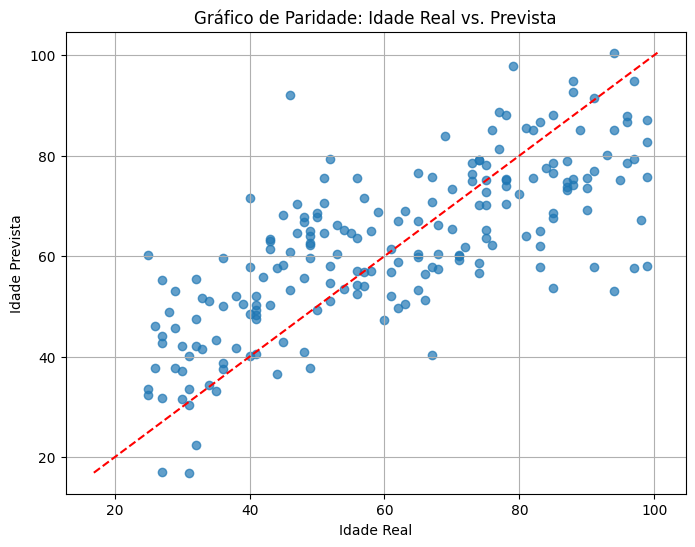

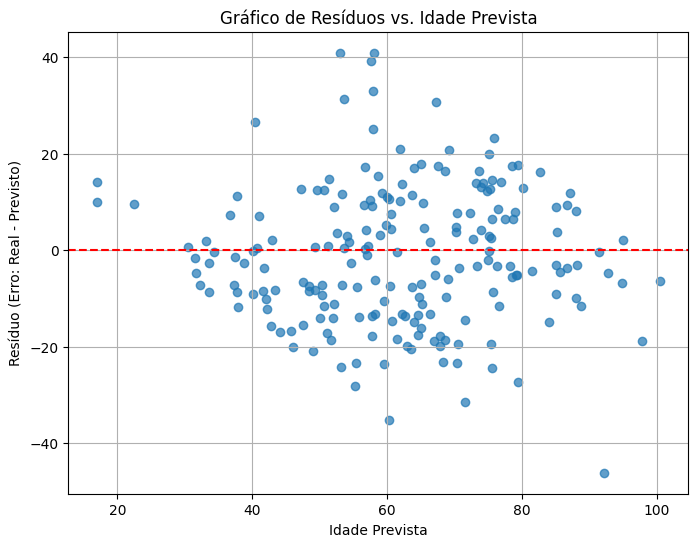

In [12]:
import numpy as np
import pandas as pd

# Biblioteca para visualização de gráficos
import matplotlib.pyplot as plt

# Funções do Scikit-learn para Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


# --- Geração de Dados ---

# Semente aleatória para garantir que nossos resultados sejam os mesmos sempre que rodarmos
RANDOM_STATE = 42

rng = np.random.default_rng(RANDOM_STATE)

n_size = 800

df_household = pd.DataFrame({
    "n_members": rng.integers(1,8, size= n_size),
    "children": rng.integers(1,4, size= n_size),
    "rooms": rng.integers(1,5, size= n_size),
    "urban": rng.choice(['Urban', 'Rural'], size=n_size, p=[0.3,0.7]),
    "region": rng.choice(['Norte', 'Nordeste', 'Sul', 'Sudeste', 'Centro-Oeste'], size=n_size, p=[0.08, 0.02, 0.75, 0.1, 0.05]),
    "internet": rng.choice(['Yes', 'No'], size=n_size, p=[0.48, 0.52]),
    "age_head": rng.integers(25, 100, size=n_size)
})

#A quantidade normal de erros é 0, e o desvio padrão é 600. 600 não é um limite máximo que o erro terá, mas sim uma medida que indica onde a maioria dos erros vai se concentrar
e = rng.normal(0, 600, size=n_size)

# Criando a coluna de renda familiar (variável target) -> Renda = (fator_membros) + (fator_quartos) + ... + (fator_região_numerica) + (ruído_aleatório)
df_household["household_income"] = (
    # fórmula ?aleatória? para gerar a renda
    500*df_household["n_members"] - 300*df_household["children"] + 800*df_household["rooms"] + 30*df_household["age_head"] + 
    # 2500 se for urbano, -500 se for rural -> df_household["urban"]=="urban" seria o mesmo que df_household["urban"]!=null
    np.where(df_household["urban"]=="urban", 2500, -500) + 
    # mapeamento e conversão/substituição de valores categóricos para valores numéricos // values: retornando os valores do df_household["region"]
    df_household["region"].map({"Norte":-400, "Nordeste":-200, "Sudeste":1000, "Sul":600, "Centro-Oeste":300}).values +
    # Somando os erros
    e
    # Garantindo que o valor final da renda seja, no mínimo, 500 (substituindo por 500 os valores menores que 500)
).clip(lower=500)


# --- Definição do target (y) e das Features (X) ---
target_col = "age_head"
y = df_household[target_col]
x = df_household.drop(columns=[target_col])  # as features são todas menos a target_col

print(f"Nova Variável Alvo (y): '{target_col}'")
print(f"Novas Variáveis Preditoras (x): {x.columns.tolist()}")


# --- Separação dos tipos de coluna ---
# Armazenando nomes das colunas em 'x' que são do tipo numérico.
num_cols = x.select_dtypes(include=np.number).columns.tolist()

#  Armazenando nomes das colunas em 'x' que NÃO são do tipo numérico.
cat_cols = x.select_dtypes(exclude=np.number).columns.tolist()

print("\nColunas numéricas para previsão:", num_cols)
print("Colunas categóricas para previsão:", cat_cols)


# --- Divisão em treino e teste ---

# Usa a função importada para dividir x e y
# test_size=0.25 significa que 25% dos dados irão para o conjunto de teste
# random_state=RANDOM_STATE garante que a divisão seja sempre a mesma
# Retorno: características de treino e de teste (x), alvo de treino e de teste (y)
x_tr, x_te, y_tr, y_te = train_test_split(x, y, test_size=0.25, random_state=RANDOM_STATE)

print(f"\nTamanho dos dados de treino (x_tr): {x_tr.shape}")
print(f"Tamanho dos dados de teste (x_te): {x_te.shape}")


# --- Construção do Pipeline ---

# Criando uma instância do ColumnTransformer para definir as regras de pré-processamento dos dados.
preprocess = ColumnTransformer(
    # 'transformers' é uma lista de tuplas, onde cada tupla é uma instrução de transformação.
    transformers=[
        # Tupla 1: ("nome", transformador, colunas_a_aplicar)
        # Aplica o StandardScaler (padronização) às colunas da lista 'num_cols'.
        ("num", StandardScaler(), num_cols),
        # Tupla 2: Aplica o OneHotEncoder (transforma texto em colunas de 0s e 1s) às colunas da lista 'cat_cols'.
        # 'handle_unknown="ignore"' evita erros se uma categoria aparecer no teste mas não no treino.
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)
    ])

# Cria o pipeline final.
model = Pipeline(
    # 'steps' é uma lista de tuplas, onde cada tupla é uma etapa do fluxo.
    steps=[
        # Etapa 1: ("nome_da_etapa", objeto_da_etapa)
        # Primeiro, aplica o pré-processamento que definimos acima.
        ("prep", preprocess),
        # Etapa 2: Depois de pré-processar, os dados são passados para o modelo de Regressão Linear.
        ("linreg", LinearRegression())
    ]
)


# --- Treinamento e teste do modelo ---

# Imprime uma mensagem para indicar o início do treinamento
print("\nTreinando o modelo para prever a idade...")
# O método .fit() treina todo o pipeline. Ele aplica o 'preprocess' em X_tr e depois treina o 'linreg' com os dados processados e y_tr
model.fit(x_tr, y_tr)
# Confirma que o treinamento terminou.
print("Treinamento concluído.")

# Usa o pipeline já treinado para fazer previsões nos dados de teste (X_te)
# O pipeline aplica automaticamente o mesmo pré-processamento aprendido no treino antes de prever
y_hat = model.predict(x_te)

# Calcula as métricas de erro comparando os valores reais do teste (y_te) com os valores previstos (y_hat)
mae = mean_absolute_error(y_te, y_hat)
rmse = np.sqrt(mean_squared_error(y_te, y_hat))
r2 = r2_score(y_te, y_hat)

# Imprime os resultados formatados para fácil leitura. Adicionamos "anos" para dar contexto ao erro
print("\n--- Métricas no Conjunto de Teste (Alvo: Idade) ---")
print(f"  MAE: {mae:,.2f} anos")
print(f"  RMSE: {rmse:,.2f} anos")
print(f"  R²: {r2:,.4f}")


# --- Visualização dos Resultados ---

# --- Gráfico de Paridade (target Real vs. target Previsto) ---
# Cria uma nova figura para o gráfico com um tamanho específico
plt.figure(figsize=(8, 6))
# Cria um gráfico de dispersão com o target real no eixo X e o target previsto no eixo Y
plt.scatter(y_te, y_hat, alpha=0.7)
# Encontra os valores mínimo e máximo para desenhar a linha de 45 graus (previsão perfeita)
min_val = min(y_te.min(), y_hat.min())
max_val = max(y_te.max(), y_hat.max())
# Desenha a linha de referência vermelha e tracejada ('r--'), que representa a previsão perfeita (y=x)
plt.plot([min_val, max_val], [min_val, max_val], 'r--')
# Adiciona rótulos aos eixos e um título ao gráfico
plt.xlabel("Idade Real")
plt.ylabel("Idade Prevista")
plt.title("Gráfico de Paridade: Idade Real vs. Prevista")
# Adiciona uma grade ao fundo para facilitar a leitura
plt.grid(True)
# Exibe o gráfico
plt.show()

# --- Gráfico de Resíduos ---
# Calcula os erros (resíduos) subtraindo a previsão do valor real
residuos = y_te - y_hat
# Cria uma nova figura para o segundo gráfico
plt.figure(figsize=(8, 6))
# Cria um gráfico de dispersão com a idade prevista no eixo X e os erros no eixo Y
plt.scatter(y_hat, residuos, alpha=0.7)
# Desenha uma linha horizontal em y=0, que representa o erro zero
plt.axhline(0, color='r', linestyle='--')
# Adiciona rótulos e título
plt.xlabel("Idade Prevista")
plt.ylabel("Resíduo (Erro: Real - Previsto)")
plt.title("Gráfico de Resíduos vs. Idade Prevista")
# Adiciona a grade
plt.grid(True)

# Exibe o gráfico
plt.show()

In [6]:
df_household.head()

,n_members,children,rooms,urban,region,internet,age_head,household_income
0,1,1,2,Rural,Sul,No,76,3555.639487
1,6,1,3,Rural,Sul,No,46,5682.003714
2,5,2,4,Rural,Centro-Oeste,Yes,44,7031.556346
3,4,3,2,Rural,Sul,No,34,5273.468741
4,4,3,1,Urban,Sul,Yes,25,2464.550528
